In [1]:
import numpy as np
import matplotlib.pyplot as plt

from monte_carlo import MCAgent
from envs.gridworld import GridworldEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

In [2]:
nx, ny = 5, 5
env = GridworldEnv([ny, nx])

In [3]:
mc_agent = MCAgent(gamma=1.0,
                   lr=1e-3,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0)

In [4]:
action_mapper = {
    0: 'UP',
    1: 'RIGHT',
    2: 'DOWN',
    3: 'LEFT'
}

In [5]:
step_counter = 0
while True:
    print("At t = {}".format(step_counter))
    #env._render()
    
    cur_state = env.observe()
    action = mc_agent.get_action(cur_state)
    next_state, reward, done, info = env.step(action)
    
    print("state : {}".format(cur_state))
    print("aciton : {}".format(action_mapper[action]))
    print("reward : {}".format(reward))
    print("next state : {} \n".format(next_state))
    step_counter += 1
    if done:
        break

At t = 0
state : 14
aciton : UP
reward : -1.0
next state : 9 

At t = 1
state : 9
aciton : LEFT
reward : -1.0
next state : 8 

At t = 2
state : 8
aciton : LEFT
reward : -1.0
next state : 7 

At t = 3
state : 7
aciton : LEFT
reward : -1.0
next state : 6 

At t = 4
state : 6
aciton : UP
reward : -1.0
next state : 1 

At t = 5
state : 1
aciton : RIGHT
reward : -1.0
next state : 2 

At t = 6
state : 2
aciton : RIGHT
reward : -1.0
next state : 3 

At t = 7
state : 3
aciton : LEFT
reward : -1.0
next state : 2 

At t = 8
state : 2
aciton : LEFT
reward : -1.0
next state : 1 

At t = 9
state : 1
aciton : DOWN
reward : -1.0
next state : 6 

At t = 10
state : 6
aciton : UP
reward : -1.0
next state : 1 

At t = 11
state : 1
aciton : DOWN
reward : -1.0
next state : 6 

At t = 12
state : 6
aciton : DOWN
reward : -1.0
next state : 11 

At t = 13
state : 11
aciton : UP
reward : -1.0
next state : 6 

At t = 14
state : 6
aciton : RIGHT
reward : -1.0
next state : 7 

At t = 15
state : 7
aciton : RIGHT
re

In [6]:
def run_episode(env, agent):
    env.reset()
    states = []
    actions = []
    rewards = []
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    episode = (states, actions, rewards)
    agent.update_stats(episode)

In [7]:
%%time
mc_agent.reset_statistics()
for _ in range(10):  
    run_episode(env, mc_agent)

Wall time: 13.7 ms


In [8]:
mc_agent.compute_values()

In [9]:
mc_agent.v

array([  0.        ,  -1.33332889, -30.41664132, -41.2856848 ,
       -58.63631033, -17.7999644 , -15.7999842 , -29.13331391,
       -35.94998203, -58.95235288, -25.4285351 , -14.49998188,
       -16.27271248, -22.99998083, -50.07688456, -28.2999717 ,
       -26.6999733 , -19.4999805 ,  -8.8999911 , -21.63634397,
       -27.34998633, -31.99997333, -28.83328528, -10.99998429,
         0.        ])

## Monte-carlo 방식으로 추산한 $V(s)$ 이 정말 맞을까요?

우리는 이 `GridworldEnv` 에 대해서 정답을 알고 있죠? 바로 `동적 계획법`을 통해서 계산한 $V(s)$ 입니다. 여기서는 `Monte-carlo` 로 추산한 가치함수와 동적 계획법으로 계산한 가치함수의 값을 비교해볼까요?

In [10]:
from tensorized_dp import TensorDP

dp_agent = TensorDP()
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Num. state = 25 | Num. actions = 4 


In [94]:
%%time
v_pi = dp_agent.policy_evaluation()

Wall time: 5.98 ms


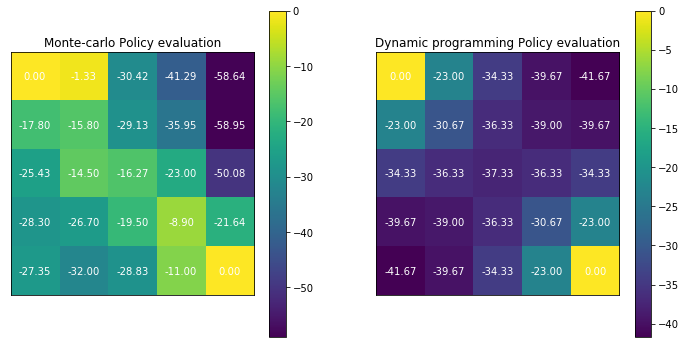

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], mc_agent.v, nx, ny)
_ = ax[0].set_title("Monte-carlo Policy evaluation")

visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("Dynamic programming Policy evaluation")

## Monte-carlo 기법에 실망하셨나요? 

`dp_agent` 와 `mc_agent`에게 비슷한 시간을 주고 가치 함수를 평가해봤었는데
`mc_agent` 의 결과가 영 시원치 않죠? 바로 `MDP` 환경모델을 활용 여부에 따른 차이입니다.

`dp_agent`는 환경에 대해 훤히 알고 있으니, 짧은 시간 (혹은 계산) 만에 원하는 답을 알아내는 것은
어쩌면 당연하겠죠. `mc_agent`에게 조금 더 시간을 줘 보는게 어떨까요?

In [43]:
total_eps = 2000
log_every = 500

def run_episodes(env, agent, total_eps, log_every):
    mc_values = []
    log_iters = []

    agent.reset_statistics()
    for i in range(total_eps+1):  
        run_episode(env, agent)

        if i % log_every == 0:
            agent.compute_values()
            mc_values.append(agent.v.copy())
            log_iters.append(i)
    
    info = dict()
    info['values'] = mc_values
    info['iters'] = log_iters
    return info

In [14]:
info = run_episodes(env, mc_agent, total_eps, log_every)

In [15]:
log_iters = info['iters']
mc_values = info['values']

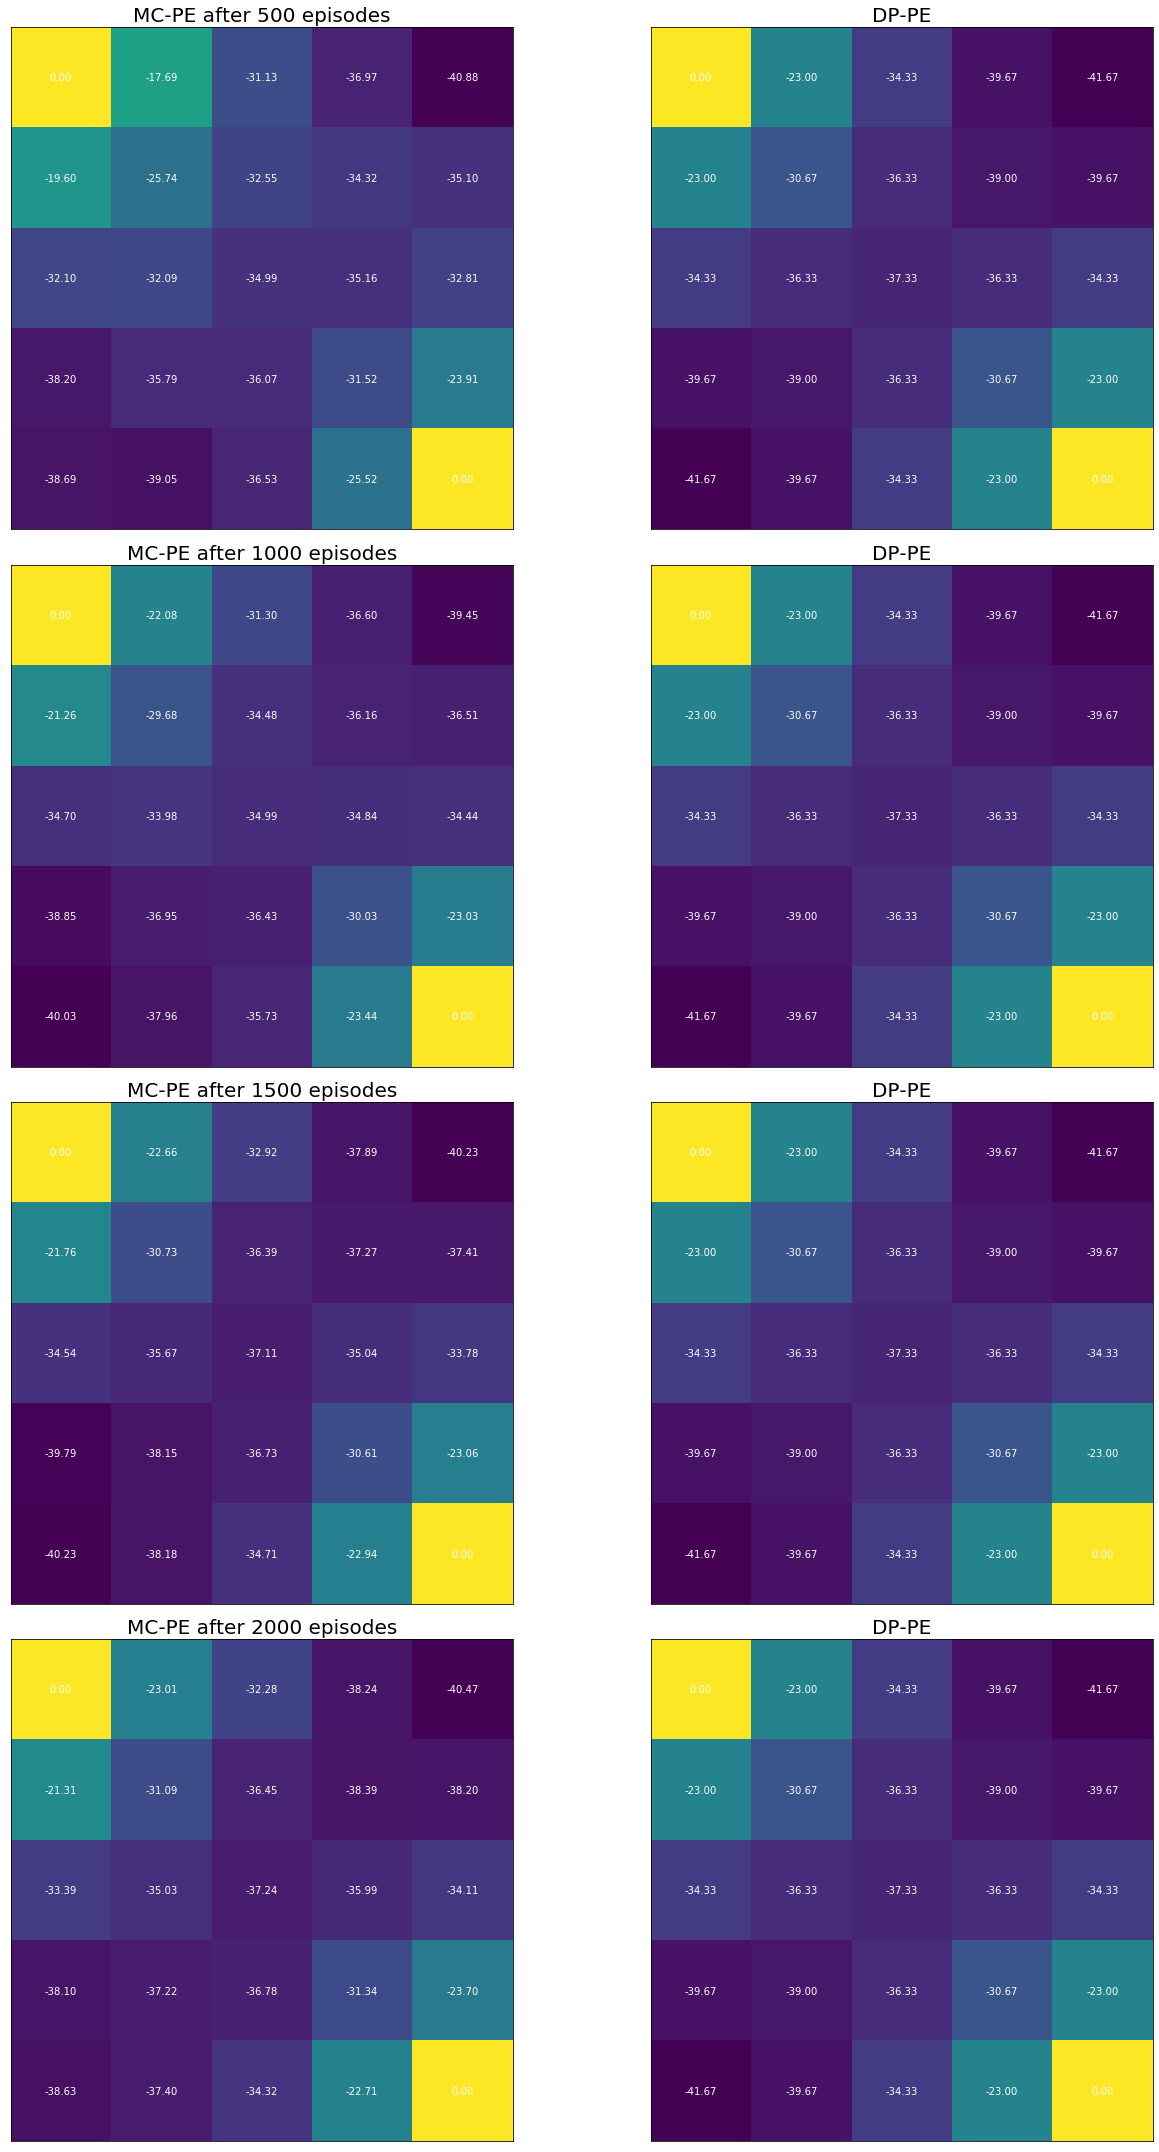

In [16]:
n_rows = len(log_iters)
figsize_multiplier = 10


fig, ax = plt.subplots(n_rows, 2, figsize=(n_rows*figsize_multiplier*0.5, 
                                           3*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("MC-PE after {} episodes".format(i), size=20)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=20)

fig.tight_layout()

## 혹시 눈치 채셨나요? 매 실행마다 결과값이 달라진다는 것을?

Monte-carlo Policy evaluation 에서는 매 실행마다, 가치함수 추산값이 달라지는것을 확인하셨나요?
그러면 한번 매 실행마다 얼마나 결과값이 다른지, 즉, 가치함수 `추산치의 분산`이 얼마나 되는지 확인해볼까요?

In [85]:
reps = 30
values_over_runs = []
total_eps = 100
log_every = 5

for i in range(reps):
    print("start to run {} th experiment ... ".format(i))
    info = run_episodes(env, mc_agent, total_eps, log_every)
    values_over_runs.append(info['values'])
    
values_over_runs = np.stack(values_over_runs)

start to run 0 th experiment ... 
start to run 1 th experiment ... 
start to run 2 th experiment ... 
start to run 3 th experiment ... 
start to run 4 th experiment ... 
start to run 5 th experiment ... 
start to run 6 th experiment ... 
start to run 7 th experiment ... 
start to run 8 th experiment ... 
start to run 9 th experiment ... 
start to run 10 th experiment ... 
start to run 11 th experiment ... 
start to run 12 th experiment ... 
start to run 13 th experiment ... 
start to run 14 th experiment ... 
start to run 15 th experiment ... 
start to run 16 th experiment ... 
start to run 17 th experiment ... 
start to run 18 th experiment ... 
start to run 19 th experiment ... 
start to run 20 th experiment ... 
start to run 21 th experiment ... 
start to run 22 th experiment ... 
start to run 23 th experiment ... 
start to run 24 th experiment ... 
start to run 25 th experiment ... 
start to run 26 th experiment ... 
start to run 27 th experiment ... 
start to run 28 th experiment 

In [95]:
v_pi_expanded = np.expand_dims(v_pi, axis=(0,1))

In [96]:
errors = np.linalg.norm(values_over_runs - v_pi_expanded, axis=-1)
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)

In [98]:
v_pi_expanded.shape

(1, 1, 25)

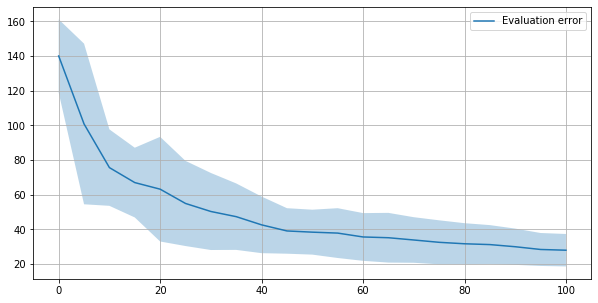

In [99]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='Evaluation error')
ax.legend()

In [42]:
error_mean

array([13.75573298,  8.66964253,  7.31661697,  6.50860802])